# Определение стоимости автомобилей

В данном проекте разрабатывается приложение для привлечения новых клиентов для сервиса по продаже автомобилей с пробегом «Не бит, не крашен». Приложение позволяет быстро узнать рыночную стоимость своего автомобиля. Для построении модели используются исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**
Данные находятся в файле /datasets/autos.csv.

Признаки

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

Целевой признак

    Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas import DataFrame

from catboost import CatBoostRegressor
from catboost import cv, Pool


import time
import seaborn as sns

from fast_ml.model_development import train_valid_test_split
from category_encoders.m_estimate import MEstimateEncoder



In [2]:
data=pd.read_csv('/datasets/autos.csv')

In [3]:
data_len=data.shape[0]

### обзорная информация 

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


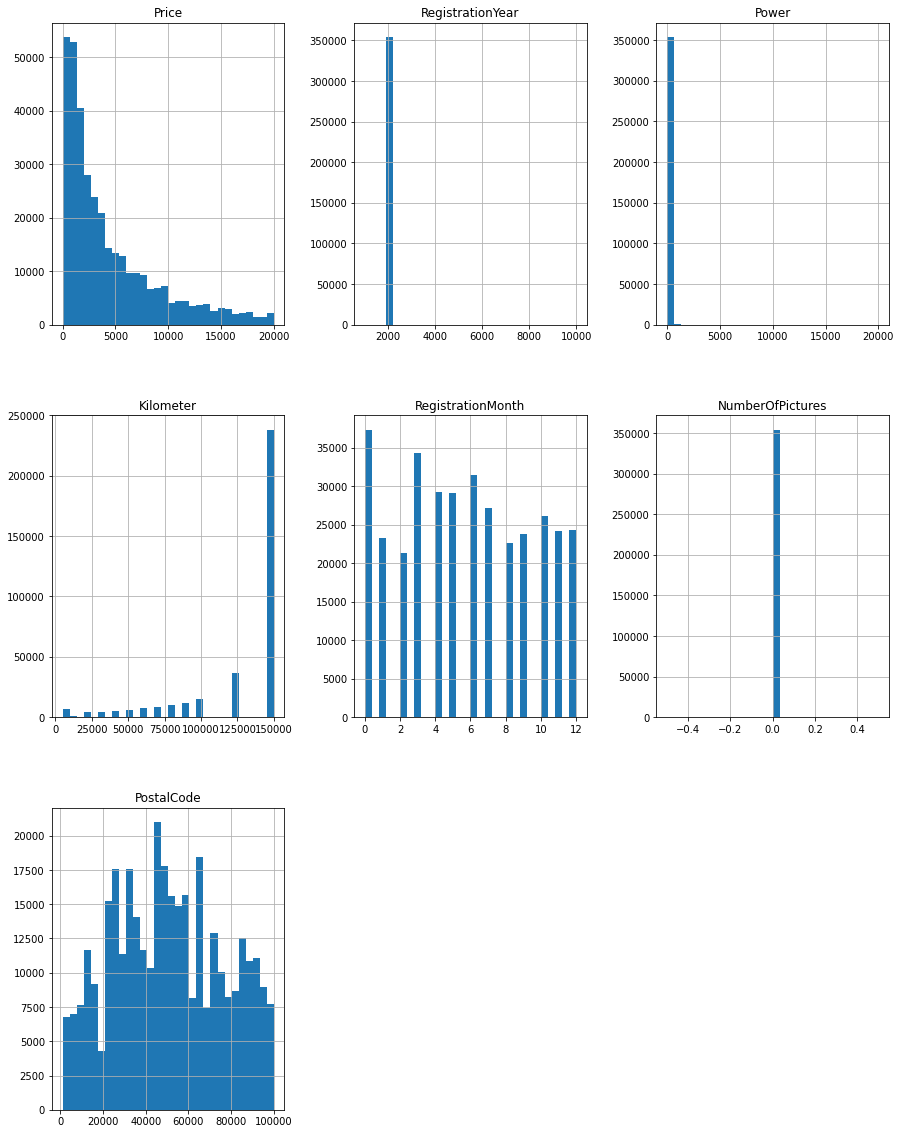

In [7]:
data.hist(figsize=(15,20),bins=30);

###  Price

<AxesSubplot:>

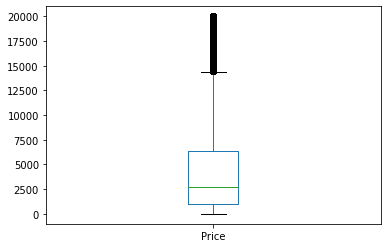

In [8]:
data['Price'].plot(kind='box')

In [9]:
(1-data.query('Price<20000 and Price > 1').shape[0]/data.shape[0])

0.0345092262585045

In [10]:
(1-data.query('Price>100').shape[0]/data.shape[0])

0.04048040319553914

In [11]:
data=data.query('Price > 100')

### Power 

<AxesSubplot:>

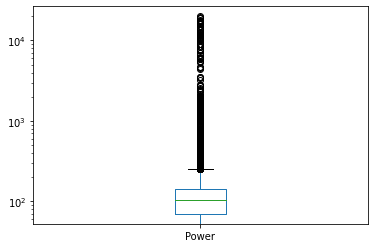

In [12]:
data['Power'].plot(kind='box',logy=True)

In [13]:
data.query('Power>500')['Power'].count()/data.shape[0]

0.001226384019951533

In [14]:
data=data.query('Power<500')

###  RegistrationYear

In [15]:
LOWEST_YEAR=1980

In [16]:
for c in ['DateCreated','DateCrawled','LastSeen']:
    data[c]=pd.to_datetime(data[c],format='%Y-%m-%d %H:%M:%S')

In [17]:
for c in ['DateCreated','DateCrawled','LastSeen']:
    print(c,'->', list(pd.DatetimeIndex(data[c]).year.unique()))

DateCreated -> [2016, 2015, 2014]
DateCrawled -> [2016]
LastSeen -> [2016]


In [18]:
data['DateCreated_year']=pd.DatetimeIndex(data[c]).year

In [19]:
data.query('RegistrationYear>DateCreated_year')['RegistrationYear'].shape[0]/data.shape[0]

0.04018010960888886

In [20]:
query_limits='RegistrationYear<=2016 and RegistrationYear>=@LOWEST_YEAR and RegistrationYear<=DateCreated_year'

<AxesSubplot:>

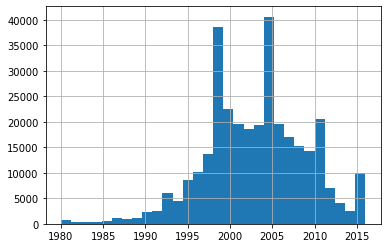

In [21]:
data.query(query_limits)['RegistrationYear'].hist(bins=30)

In [22]:
100-100*len(data.query(query_limits))/len(data)

4.91473064543203

In [23]:
data=data.query(query_limits)

In [24]:
data=data.drop(columns='DateCreated_year')

### PostalCode

In [25]:
data['PostalCode'].unique().shape

(8131,)

In [26]:
data.groupby('PostalCode').count()['Price'].sort_values()

PostalCode
92549      1
96196      1
91362      1
98678      1
91369      1
        ... 
32257    279
44145    284
66333    301
65428    562
10115    808
Name: Price, Length: 8131, dtype: int64

In [27]:
# data['PostalCode']=data['PostalCode'].astype('object')

Признак PostalCode по своей сути категориальный, но уникальных значенией очень много 8142, да и релевантость признака под вопросом. Поэтому этот признак будет удален. 

### Удаление признаков

Удаляются признаки 'NumberOfPictures','DateCreated','LastSeen', 'DateCrawled'

In [28]:
data['NumberOfPictures'].sum()

0

In [29]:
data=data.drop(columns=['DateCrawled','DateCreated','NumberOfPictures','LastSeen','PostalCode'])

### RegistrationMonth

In [30]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [31]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006, 1999,
       2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982, 1983,
       1987, 1986, 1988, 1980])

### Категориальные признаки

In [32]:
features_categorical=data.select_dtypes(exclude=['int64']).columns
features_numerical=data.drop(['Price'],axis=1).select_dtypes(exclude=['object']).columns
print(features_categorical)
features_numerical


Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], dtype='object')


Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'], dtype='object')

In [33]:
data[features_numerical].corr()

,RegistrationYear,Power,Kilometer,RegistrationMonth
RegistrationYear,1.000000,0.142279,-0.327755,0.054942
Power,0.142279,1.000000,0.071270,0.103613
Kilometer,-0.327755,0.071270,1.000000,-0.008571
RegistrationMonth,0.054942,0.103613,-0.008571,1.000000


In [34]:
features_numerical_all=data.select_dtypes(exclude=['object']).columns
data[features_numerical_all].corr()['Price'].sort_values()

Kilometer           -0.366913
RegistrationMonth    0.089272
Power                0.497163
RegistrationYear     0.544565
Price                1.000000
Name: Price, dtype: float64

### Пропуски

In [35]:
(100 *data.isna().sum()/data.shape[0]).sort_values()

Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
Gearbox               4.298474
Model                 4.427004
VehicleType           5.675138
FuelType              6.883010
Repaired             17.655366
dtype: float64

In [36]:
[{i:data[i].unique()} for i in ['VehicleType','Model','Gearbox','FuelType','Repaired']]

[{'VehicleType': array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
         'wagon', 'other'], dtype=object)},
 {'Model': array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
         '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
         'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
         'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
         '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
         'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
         'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
         'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
         '7er', '80', '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza',
         'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
         'lupo', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
         'vectra', 'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda',
 

In [37]:
data=data.fillna('unknown')
data.isna().sum().sum()

0

### Дубликаты

In [38]:
data=data.drop_duplicates()

In [39]:
1-data.shape[0]/data_len

0.16000270904057634

### Выводы



Проведены предобработка данных:
- Доля пропусков высокая 5-20 %. Пропуски только к категориальных признаках. Пропуски были заменены на строку 'unknown'. 
- Признак `NumberOfPictures` убран из данных посколько состоит только из нулей. 
- Признак PostalCode по своей сути категориальный, но уникальных значенией очень много 8142, да и релевантость признака под вопросом. Поэтому этот признак будет удален. 
- Созданы списки категориальных и числовых признаков
- Удалены 1% данных с признаком RegistrationYear меньше чем 1980 и больше 2023 года
- убраны дубликаты
- исключены данные в которых дата регистрации машины позже чем заведена анкета или позже 2016 года когда была скачена анкета

Суммарно 8.9% были рассмотрены как ошибочные и были удалены в предобработке

## Обучение моделей

In [40]:
fitting=True
SEED=12345
cv_fold = StratifiedKFold(n_splits=5, random_state=SEED,shuffle=True)

In [41]:
timing_dict={}

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297669 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              297669 non-null  int64 
 1   VehicleType        297669 non-null  object
 2   RegistrationYear   297669 non-null  int64 
 3   Gearbox            297669 non-null  object
 4   Power              297669 non-null  int64 
 5   Model              297669 non-null  object
 6   Kilometer          297669 non-null  int64 
 7   RegistrationMonth  297669 non-null  int64 
 8   FuelType           297669 non-null  object
 9   Brand              297669 non-null  object
 10  Repaired           297669 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.3+ MB


In [43]:
features = data.drop(['Price'],axis=1)  #'RowNumber'
features.shape

(297669, 10)

In [44]:
target=data['Price']
target.shape

(297669,)

lf=list(features_categorical)
features0=pd.get_dummies(features,drop_first=True,columns=lf)

### One-hot encoding

In [45]:
features_ohe=pd.get_dummies(features,drop_first=True,columns=list(features_categorical))

In [46]:
features_categorical

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], dtype='object')

In [47]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
## passing bridge-types-cat column (label encoded values of bridge_types)
# enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())


In [48]:
features_ohe_train, features_ohe_test, target_train, target_test = train_test_split(
    features_ohe, target, test_size=0.2, random_state=12345)

#features_ohe_train, features_ohe_valid, target_train, target_valid = train_test_split(
#    features_ohe_train, target_train, test_size=0.25, random_state=12345)

### MEstimateEncoder

In [49]:
#pip install fast_ml

In [50]:
X_train,y_train,X_valid,y_valid,X_test,y_test=train_valid_test_split(data,target='Price',
                train_size=0.6,valid_size=0.2,test_size=0.2,random_state=12345)

In [51]:
for c in features_categorical:
    print(c,'->',data[c].unique().shape)

VehicleType -> (9,)
Gearbox -> (3,)
Model -> (249,)
FuelType -> (8,)
Brand -> (40,)
Repaired -> (3,)


In [52]:
# pip install category_encoders

In [53]:
%%time
MEE_encoder = MEstimateEncoder()
X_train_mee = MEE_encoder.fit_transform(X_train[features_categorical], y_train)
X_valid_mee = MEE_encoder.transform(X_valid[features_categorical])
X_test_mee = MEE_encoder.transform(X_test[features_categorical])

CPU times: user 1.29 s, sys: 32.7 ms, total: 1.32 s
Wall time: 1.32 s


In [54]:
X_train_mee=X_train[features_numerical].join(X_train_mee)
X_valid_mee=X_valid[features_numerical].join(X_valid_mee)
X_test_mee=X_test[features_numerical].join(X_test_mee)

### Маштабирование

In [56]:
scalar= StandardScaler()
numeric=features_numerical
scalar.fit(features_ohe_train[numeric])

pd.options.mode.chained_assignment = None
features_ohe_train[numeric]=scalar.transform(features_ohe_train[numeric])
#features_ohe_valid[numeric]=scalar.transform(features_ohe_valid[numeric])
features_ohe_test[numeric]=scalar.transform(features_ohe_test[numeric])

In [57]:
scalar_mee= StandardScaler()
pd.options.mode.chained_assignment = None
#X_train_mee[features_numerical_] = scalar_mee.fit_transform(X_train_mee[features_numerical], y_train)
#X_valid_mee[features_numerical_] = scalar_mee.transform(X_valid_mee[features_numerical])
#X_test_mee[features_numerical_] = scalar_mee.transform(X_test_mee[features_numerical])
X_train_mee = scalar_mee.fit_transform(X_train_mee, y_train)
X_valid_mee = scalar_mee.transform(X_valid_mee)
X_test_mee = scalar_mee.transform(X_test_mee)

In [58]:
features_ohe_train, target_train = X_train_mee,y_train
features_ohe_valid, target_valid = X_valid_mee, y_valid
features_ohe_test, target_test   = X_test_mee, y_test

### Dummy model

In [59]:
model_dummy = DummyRegressor(strategy='mean')

start=time.time()
model_dummy.fit(features_ohe_train,target_train)
time_fit=time.time()-start

In [60]:
start=time.time()
prediction_dummy = model_dummy.predict(features_ohe_test)
time_predict=time.time()-start

rmse=mean_squared_error(target_test,prediction_dummy, squared=False)
print('RMSE for mean value', rmse)

RMSE for mean value 4521.339112503214


In [61]:
timing_dict['dummy']=[time_fit,time_predict,rmse]

In [62]:
timing_dict

{'dummy': [0.0007390975952148438, 0.00042510032653808594, 4521.339112503214]}

### Linear model

In [63]:
%%time 
model_lin=LinearRegression()
start=time.time()
model_lin.fit(features_ohe_train,target_train)
time_fit=time.time()-start

CPU times: user 51.6 ms, sys: 3.43 ms, total: 55 ms
Wall time: 32.8 ms


In [64]:
start=time.time()
prediction_lin = model_lin.predict(features_ohe_test)
time_predict=time.time()-start
rmse=mean_squared_error(target_test,prediction_lin, squared=False)
print('RMSE for mean value', rmse)
# RMSE for mean value 2535.389329557741

RMSE for mean value 2703.4143376393777


In [65]:
timing_dict['linear']=[time_fit,time_predict,rmse]

In [66]:
timing_dict

{'dummy': [0.0007390975952148438, 0.00042510032653808594, 4521.339112503214],
 'linear': [0.03273296356201172, 0.0018453598022460938, 2703.4143376393777]}

### Decision tree 

In [67]:
if fitting:
    start=time.time()
    parameters_grid = { 
        'max_depth':[8,16],
        #'criterion':['gini', 'entropy'],
        'min_samples_leaf':[2,5]
        }
    print('Количество моделей', np.prod([len(i) for i in parameters_grid.values()]))
    model = DecisionTreeRegressor(random_state=12345)
    cv_tree = GridSearchCV(estimator=model, param_grid=parameters_grid , cv= cv_fold, scoring='neg_mean_squared_error',verbose=2)    
    cv_tree.fit(features_ohe_train,target_train)
    parameters=cv_tree.best_params_
    print(parameters)
    print('лучший MSE =',cv_tree.best_score_)
    time_fit=time.time()-start
    print('time_fit=',time_fit)
    
    start=time.time()
    prediction_tree=cv_tree.best_estimator_.predict(features_ohe_test)
    time_predict=time.time() - start
    print('time_predict=',time_predict)
    
    rmse_tree=mean_squared_error(target_test,prediction_tree, squared=False)
    print('RMSE for mean value', rmse_tree)
    
else:
    parameters = {'max_depth': 16, 'min_samples_leaf': 2}
    rmse_tree=np.sqrt(5180352.413150354)
    print('лучший RMSE =', rmse_tree)
    time_fit=159.6
    time_predict=1.1

Количество моделей 4
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=2; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=5; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=5; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=5; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=5; total time=   0.3s
[CV] END ....................max_depth=8, min_samples_leaf=5; total time=   0.3s
[CV] END ...................max_depth=16, min_samples_leaf=2; total time=   0.5s
[CV] END ...................

In [68]:
timing_dict['tree']=[time_fit,time_predict,rmse_tree]

In [69]:
timing_dict

{'dummy': [0.0007390975952148438, 0.00042510032653808594, 4521.339112503214],
 'linear': [0.03273296356201172, 0.0018453598022460938, 2703.4143376393777],
 'tree': [8.748639583587646, 0.011056661605834961, 1792.248352556963]}

### Random Forest

In [70]:
%%time

if fitting:
    parameters_grid = {
        'n_estimators': [8,12] #, 
#        'max_depth': [6,10], 
#        'min_samples_split': [2, 3]
        }
    print('Количество моделей', np.prod([len(i) for i in parameters_grid.values()]))
    model = RandomForestRegressor(random_state=12345)
    cv_forest = GridSearchCV(
        estimator=model, 
        param_grid=parameters_grid , 
        #cv=False, 
        scoring='neg_mean_squared_error',
        verbose=1)
    time_fit=-time.time()
    cv_forest.fit(features_ohe_train,target_train)
    time_fit+=time.time()
    print('time_fit=',time_fit)
    
    parameters=cv_forest.best_params_
    
    print('parameters=',parameters)
    print('best score=',-cv_forest.best_score_)
    
    start=time.time()
    prediction_forest=cv_forest.best_estimator_.predict(features_ohe_test)
    time_predict=time.time() - start
    print('time_predict=',time_predict)
    
    rmse_forest=mean_squared_error(target_test,prediction_forest, squared=False)
    print('RMSE for mean value', rmse_tree)

else:
    parameters= {'n_estimators': 12}
    time_fit= 865.688577413559
    time_predict= 0.5902400016784668
    rmse_forest= 2279.158454734247

Количество моделей 2
Fitting 5 folds for each of 2 candidates, totalling 10 fits
time_fit= 50.79045128822327
parameters= {'n_estimators': 12}
best score= 2782545.3870820105
time_predict= 0.3423783779144287
RMSE for mean value 1792.248352556963
CPU times: user 50.7 s, sys: 381 ms, total: 51.1 s
Wall time: 51.1 s


In [71]:
timing_dict['forest']=[time_fit,time_predict,rmse_forest]

### LightGBM

In [72]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    ###'learnnig_rage': 0.05,
   ### 'categorical_feature':cat_features,
    'metric': {'rmse'}, #''l2','l1'},
    'verbose': -1
}

In [73]:
# laoding data
lgb_train = lgb.Dataset(features_ohe_train, target_train)
lgb_eval = lgb.Dataset(features_ohe_test, target_test, reference=lgb_train)

In [74]:
# fitting the model
time_fit=-time.time()
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30
                #, categorical_feature=cat_features
                 )
time_fit+=time.time()
print('time_fit=',time_fit)

[1]	valid_0's rmse: 4236.74
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 3985.14
[3]	valid_0's rmse: 3761.21
[4]	valid_0's rmse: 3563.58
[5]	valid_0's rmse: 3381.72
[6]	valid_0's rmse: 3223.63
[7]	valid_0's rmse: 3073.82
[8]	valid_0's rmse: 2950.64
[9]	valid_0's rmse: 2835.5
[10]	valid_0's rmse: 2736.95
[11]	valid_0's rmse: 2652.23
[12]	valid_0's rmse: 2575.2
[13]	valid_0's rmse: 2504.13
[14]	valid_0's rmse: 2438.32
[15]	valid_0's rmse: 2386.78
[16]	valid_0's rmse: 2335.91
[17]	valid_0's rmse: 2290.56
[18]	valid_0's rmse: 2248.27
[19]	valid_0's rmse: 2208.46
[20]	valid_0's rmse: 2172.99
[21]	valid_0's rmse: 2142.45
[22]	valid_0's rmse: 2114.2
[23]	valid_0's rmse: 2088.74
[24]	valid_0's rmse: 2065.76
[25]	valid_0's rmse: 2044.26
[26]	valid_0's rmse: 2027.5
[27]	valid_0's rmse: 2009.76
[28]	valid_0's rmse: 1993.08
[29]	valid_0's rmse: 1980.08
[30]	valid_0's rmse: 1966.13
[31]	valid_0's rmse: 1953.28
[32]	valid_0's rmse: 1943.29
[33]	valid_0's rmse: 193

In [75]:
# prediction
time_pred=-time.time()
target_pred = model.predict(features_ohe_test)
time_pred+=time.time()
# accuracy check
mse = mean_squared_error(target_test,target_pred)
rmse = mse**(0.5)
print("RMSE: %.2f" % rmse)


RMSE: 1734.80


In [76]:
timing_dict['lightgbm']=[time_fit,time_pred,rmse]

In [77]:
timing_dict

{'dummy': [0.0007390975952148438, 0.00042510032653808594, 4521.339112503214],
 'linear': [0.03273296356201172, 0.0018453598022460938, 2703.4143376393777],
 'tree': [8.748639583587646, 0.011056661605834961, 1792.248352556963],
 'forest': [50.79045128822327, 0.3423783779144287, 1653.2045292578284],
 'lightgbm': [155.58512568473816, 0.3196563720703125, 1734.8027899685721]}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

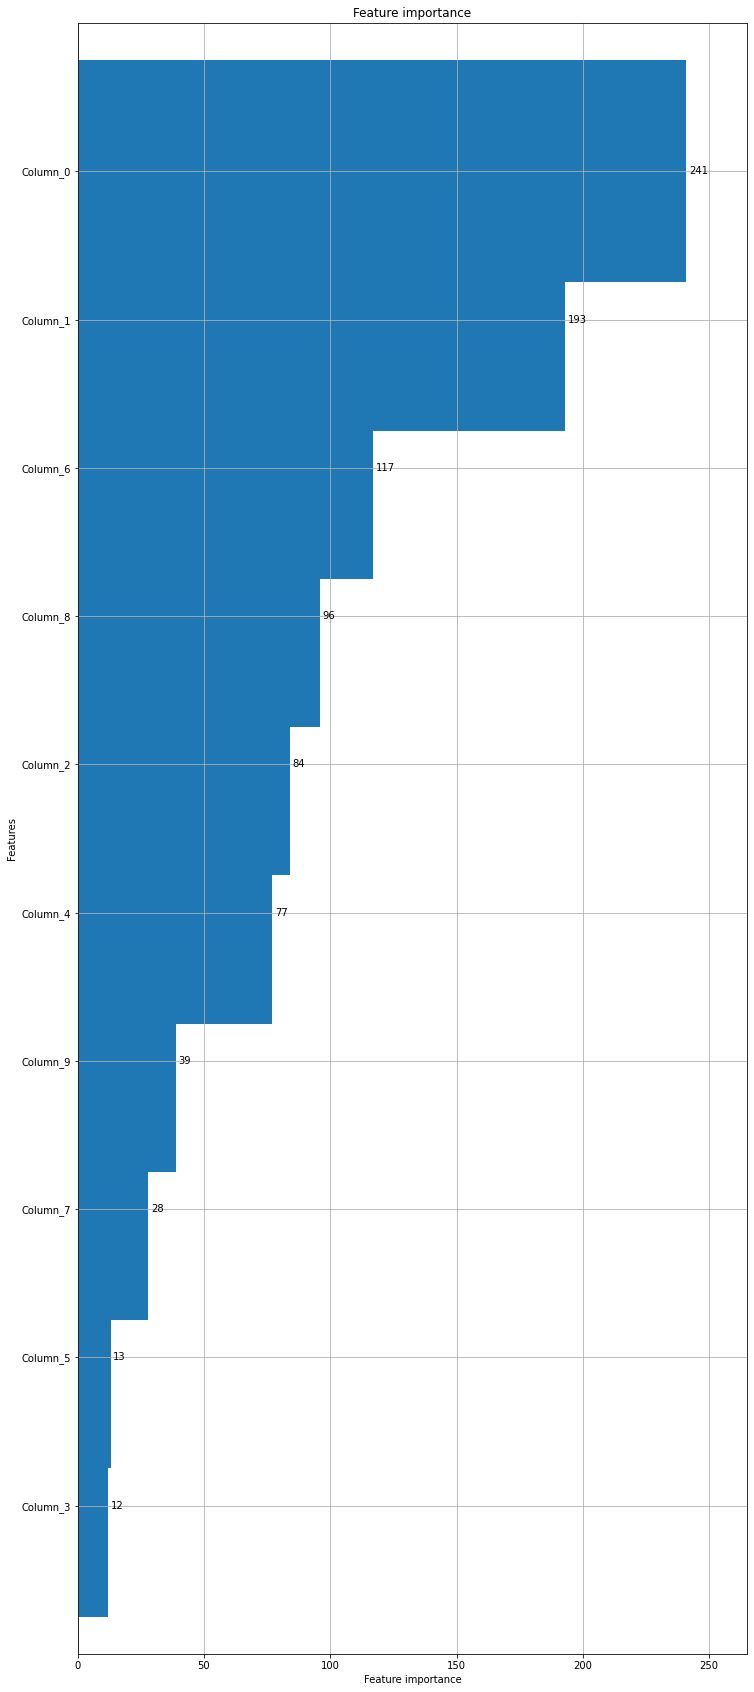

In [78]:
# plotting feature importance
lgb.plot_importance(model, height=1.5,figsize=(12, 30)) 

### CatBoost

In [79]:
train, test = train_test_split(data, train_size=0.8,random_state=2007)

In [80]:
X=list(features_categorical)+list(features_numerical)
print(X)
cat_features=list(features_categorical)
print(cat_features)
y=['Price']

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [81]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

In [82]:
params = {'cat_features': cat_features,
              'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
              'learning_rate': 1.0,
              'random_seed': 12345,
              'verbose':100}

In [83]:
time_fit=-time.time()
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=20
)
time_fit+=time.time()
print('time_fit=',time_fit)

Training on fold [0/5]

bestTest = 1608.314382
bestIteration = 198

Training on fold [1/5]

bestTest = 1597.123533
bestIteration = 188

Training on fold [2/5]

bestTest = 1625.958198
bestIteration = 115

Training on fold [3/5]

bestTest = 1632.776965
bestIteration = 153

Training on fold [4/5]

bestTest = 1601.986389
bestIteration = 180

time_fit= 229.2287619113922


In [84]:
cv_data.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,2613.281717,29.133541,2611.276644,29.194773
1,1,2323.747448,42.561779,2320.788271,32.578386
2,2,2172.106585,36.174831,2169.060230,17.102920
3,3,2065.625043,39.398693,2062.545896,17.050450
4,4,2003.807508,37.712642,2001.309576,18.064887


In [85]:
cv_data[cv_data['train-RMSE-mean'] == cv_data['train-RMSE-mean'].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
218,218,1614.421926,15.068074,1496.23323,18.24361


In [86]:
params = {'cat_features': cat_features,
          'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
          'learning_rate': 1,
          'random_seed': 12345,
          'verbose':100,
          'iterations': 312}

model = CatBoostRegressor(**params)
time_fit=-time.time()
model.fit(train_data)
time_fit+=time.time()

0:	learn: 2565.7650881	total: 379ms	remaining: 1m 57s
100:	learn: 1562.4413300	total: 27.7s	remaining: 57.9s
200:	learn: 1496.7640486	total: 53.9s	remaining: 29.7s
300:	learn: 1455.9459699	total: 1m 20s	remaining: 2.95s
311:	learn: 1452.3758702	total: 1m 23s	remaining: 0us


In [87]:
time_pred=-time.time()
test['y_pred']= model.predict(test_data)
time_pred+=time.time()
rmse = mean_squared_error(test[y],test['y_pred'],squared=False)
print(rmse)

1593.1126167655248


In [88]:
timing_dict['catboost']=[time_fit,time_pred,rmse]

### Выводы

Для 6 моделей изучено время которое требуется для обучения, время для предсказания и лучший RMSE критерий.
Размер пространства гиперпараментров был ограничен 2-3 примерами. 
Рассмотрены три одиночные модели:
- Модель среднего значения
- Дерево решений 
- Линейная модель 
и три ансамбля моделей:
- модель случайного леса (bagging)
- LightGBM (boosting)
- CatBoost (boosting)

## Анализ моделей

v0 results for timing_dict : {'dummy': [0.0018112659454345703, 0.003654003143310547, 4470.566916349361],
 'linear': [98.24061679840088, 0.1301262378692627, 2535.389329557741],
 'tree': [197.43936014175415, 1.2980849742889404, 2279.158454734247],
 'forest': [847.1832025051117, 0.7429852485656738, 1612.0332956556335],
 'lightgbm': [151.92277455329895, 0.6663196086883545, 1826.5733687031059],
 'catboost': [114.11813306808472, 0.2679862976074219, 1611.0568085995894]}

In [89]:
timing_dict

{'dummy': [0.0007390975952148438, 0.00042510032653808594, 4521.339112503214],
 'linear': [0.03273296356201172, 0.0018453598022460938, 2703.4143376393777],
 'tree': [8.748639583587646, 0.011056661605834961, 1792.248352556963],
 'forest': [50.79045128822327, 0.3423783779144287, 1653.2045292578284],
 'lightgbm': [155.58512568473816, 0.3196563720703125, 1734.8027899685721],
 'catboost': [89.15167570114136, 0.15301060676574707, 1593.1126167655248]}

In [90]:
model_data=pd.DataFrame.from_dict(timing_dict).round(1).transpose().rename(columns={0:'Fit_time', 1:'Prediction_time',2:'RMSE'})

In [91]:
model_data['name']=model_data.index

In [92]:
model_data=model_data.sort_values(by='RMSE')

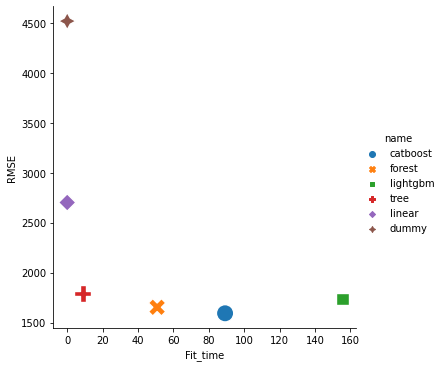

In [93]:
# Create a visualization
sns.relplot(
    data=model_data,
    x="Fit_time", y="RMSE",
    hue="name", style="name",s=300
)

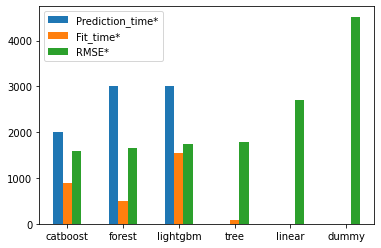

In [94]:
model_data['Prediction_time*']=model_data['Prediction_time']*10000
model_data['RMSE*']=model_data['RMSE']
model_data['Fit_time*']=model_data['Fit_time']*10
ax = model_data[['Prediction_time*','Fit_time*','RMSE*']].plot.bar(rot=0)

### Выводы

В проекте рассмотрены 6 моделей:
- Модель среднего значения
- Дерево решений 
- Линейная модель 
- модель случайного леса (bagging)
- LightGBM (boosting)
- CatBoost (boosting)

Для каждой из моделей вычислено три характеристики:
- время которое требуется для обучения, 
- время предсказания
- RMSE критерий на тестовой выборке.


Результаты представлены в сравнительной таблице и граффиках выше. 
Наилучшую точность удалось достич используя ансамбли моделей: 
- CatBoost
- Random Forest
- LightGBM

Для 'ансамблей' использования стоит выбрать CatBoost посколько он дает самые быстрые предсказания, а другие харастеристики время обучения и точность сравнимы с моделью случайного леса и LightGBM.

Простая модель  Desicion Tree показала несущественно ниже результат для метрики, но при этом она самая быстрая в обучении и в предсказании. поэтому ее следует выбрать для работы. 
